In [1]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0
!pip install pygame

from stable_baselines.common.policies import MlpPolicy
from stable_baselines import PPO2, DQN

TensorFlow 1.x selected.
     |████████████████████████████████| 248 kB 4.2 MB/s 
  Attempting uninstall: stable-baselines
    Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1
     |████████████████████████████████| 11.8 MB 4.3 MB/s 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
import os
import numpy as np
import sys
import math
import random
import time
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import gym
from gym import spaces
# from gym.envs.classic_control import rendering

from google.colab import files
from google.colab.patches import cv2_imshow
from google.colab import output

import IPython

# OOP Code

## Piece

In [3]:
class Piece:
    def __init__(self, player = 0):
        self.player = player

    def set_player(self, player):
        self.player = player

    def get_player(self):
        return self.player

## Board

In [4]:
class Board:
    def __init__(self, rows, cols):
        self.cols = cols
        self.rows = rows

        self.board = []
        for r in range(self.rows):
            self.board.append([])
            for c in range(self.cols):
                self.board[r].append(Piece())

    def get_board_values(self):
        b = []
        for r in range(self.rows):
            b.append([])
            for c in range(self.cols):
                b[r].append(self.board[r][c].get_player())
        return b

    def get_piece(self, row, col):
        return self.board[row][col]

    def put_piece(self, row, col, piece):
        self.board[row][col] = piece


## BoardController

In [5]:
class BoardController:
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols
        self.level = 1
        self.board = Board(self.rows, self.cols)

    def get_rowcols(self):
        return self.rows, self.cols

    def set_board(self, new_board):
        for ind_r, r in enumerate(new_board):
            for ind_c, c in enumerate(r):
                self.board.put_piece(ind_r, ind_c, Piece(c))

    def get_board_values(self):
        return self.board.get_board_values()

    def get_board(self):
        return self.board

    def put_piece(self, row,  col, player):
        if self.board.get_piece(row, col).get_player() != 0:
            return False

        self.board.put_piece(row, col, Piece(player))
        return True

    def check_winner(self, player):
        if self.check_horizontal(self.board, player) or self.check_vertical(self.board, player) or self.check_diagonal(self.board, player):
            return True
        return False

    def reestart_board(self):
        for r in range(self.rows):
            for c in range(self.cols):
                self.board.put_piece(r, c, Piece())

    def check_horizontal(self, board, player):
        for r in range(self.rows):
            if board.get_piece(r, 0).get_player() == player:
                if board.get_piece(r, 1).get_player() == player:
                    if board.get_piece(r, 2).get_player() == player:
                        return True
        return False

    def check_vertical(self, board, player):
        for c in range(self.cols):
            if board.get_piece(0, c).get_player() == player:
                if board.get_piece(1, c).get_player() == player:
                    if board.get_piece(2, c).get_player() == player:
                        return True
        return False

    def check_diagonal(self, board, player):
        for c in [0, 2]:
            # print c, '-', board.get_piece(0, c).get_player(), board.get_piece(1, 1).get_player(), board.get_piece(2, 2-c).get_player()
            if board.get_piece(0, c).get_player() == player:
                if board.get_piece(1, 1).get_player() == player:
                    if board.get_piece(2, 2-c).get_player() == player:
                        return True
        return False

    def check_nomoves(self):
        for c in range(self.cols):
            for r in range(self.rows):
                if self.board.get_piece(r, c).get_player() == 0:
                    return False
        return True


## UIBoard

In [6]:
import numpy as np
import os

class UIBoard:
    def __init__(self, bcontrol):
        self.b_controller = bcontrol

    def print_board_values(self):
        board = self.b_controller.get_board_values()
        print(np.matrix(board))

    def clear_terminal(self):
        os.system('cls' if os.name == 'nt' else 'clear')


## Aux

###Player

In [8]:
class Player:
    def __init__(self, number, bc):
        self.player = number
        self.b_controller = bc

    def get_number(self):
        return self.player

    def play_turn(self):

        validmove = False
        while not validmove:
            column = None
            row = None
            while column not in range(1, 4):
                print("Input a valid column (1-3):")
                column = int(input())
                # column = 1
            while row not in range(1, 4):
                print("Input a valid row (1-3):")
                row = int(input())
                # row = 3
            column -= 1
            row -= 1

            validmove = self.b_controller.put_piece(row, column, self.player)
            if not validmove:
                print('-- Please enter a valid move!!')



### GameController

In [11]:
class Controller3Row:
	def __init__(self):

		self.rows = 3
		self.columns = 3

		self.b_controller = BoardController(self.rows, self.columns)
		self.ui = UIBoard(self.b_controller)
		self.player1 = Player(1, self.b_controller)
		self.player2 = Player(2, self.b_controller)

		self.turn = 0


	def play(self):
		end = False
		self.reestart_game()
		self.ui.print_board_values()

		moves = 0
		while not end and moves < 5:

			self.turn = self.turn % 2 +1

			if self.turn == 1:
				print('Turn', moves, ': player 1')
				self.player1.play_turn()
				winner = self.b_controller.check_winner(self.player1.get_number())
			elif self.turn == 2:
				print('Turn', moves, ': player 2')
				self.player2.play_turn()
				winner = self.b_controller.check_winner(self.player2.get_number())

			self.ui.print_board_values()
			if winner:
				if self.turn == 1:
					print('Player 1 won!!')
				elif self.turn == 2:
					print('Player 2 won!!')
				end = True
			else:
				draw = self.b_controller.check_nomoves()
				if draw:
					end = True
					print('Draw!!')

			moves += 1


	def ticks2time(self, ticks):
		seconds = int((ticks/1000) % 60)
		minutes = int((ticks/(1000*60)) % 60)
		hours = int((ticks/(1000*60*60)) % 24)

		if hours > 0:
			return "{}:{}:{:02d}".format(hours, minutes, seconds)
		else:
			return "{}:{:02d}".format(minutes, seconds)

	def reestart_game(self):
		# self.b_controller.reestart_board()
		# initial_board = np.array([  [2,1,2],
		# 							[2,1,2],
		# 							[1,2,0]])
		self.b_controller.set_board(initial_board)


# CustomEnv

In [12]:
class Game3RowEnv(gym.Env):
	"""
	Custom Environment to play 3 in a row.
	"""
	metadata = {'render.modes': ['human', 'terminal']}

	def __init__(self, rows, cols, reward=1, vsAI = 1):
		super(Game3RowEnv, self).__init__()

		self.rows = rows
		self.cols = cols
		# Size of the 1Dgame grid
		self.grid_size = rows*cols
		self.moves = 0
		self.player = 1
		self.rival = 2

		self.b_controller = BoardController(self.rows, self.cols)
		self.ui = UIBoard(self.b_controller)

		# Define action and observation space
		n_actions = 9
		self.action_space = spaces.Discrete(n_actions)
		# The observation will be the coordinate of the agent
		# this can be described both by Discrete and Box space
		self.observation_space = spaces.Box(low=0, high=2,
											shape=(self.rows*self.cols, ), dtype=np.float32)

		self.list_moves = []
		self.list_states = []
		self.type_reward = reward
		self.type_AI = vsAI
		self.video = []

	def reset(self):
		"""
		Important: the observation must be a numpy array
		:return: (np.array)
		"""
		self.b_controller.reestart_board()

		self.list_moves = []
		self.list_states = []
		self.moves = 0

		obs = np.array(self.b_controller.get_board_values())
		flat_obs = obs.flatten(order='C')
		return flat_obs

	def step(self, action):
		move_row = int(action/3)
		move_col = action % 3

		validmove = self.b_controller.put_piece(move_row, move_col, self.player)

		self.list_states.append(self.b_controller.get_board_values())
		self.list_moves.append(action)
		self.moves += 1

		# Optionally we can pass additional info, we are not using that for now
		info = {'finished':False, 'list_moves':self.list_moves, 'list_states':self.list_states, 'step':self.moves}

		if validmove:
			winner = self.b_controller.check_winner(self.player)
			draw = False
			if not winner: #if it hasn't win, check draw
				draw = self.b_controller.check_nomoves()


			if not draw and not winner: #if it hasn't win nor draw, move the rival
				self.moveAI()
				loser = self.b_controller.check_winner(self.rival)
				if not loser: #if the rival hasn't won, check draw
					draw = self.b_controller.check_nomoves()


		done = False
		if self.type_reward == 1 or self.type_reward == 2:
			# REWARD: 1 if win, -1 if loss, 0 rest, if invalid move -10
			if not validmove:
				reward = -10
				if self.type_reward == 1:
					info['finished'] = 'invalid'
					done = True
			elif winner:
				info['finished'] = 'win'
				reward = 1
				done = True
			elif draw:
				info['finished'] = 'draw'
				reward = 0
				done = True
			elif loser:
				info['finished'] = 'lose'
				reward = -1
				done = True
			else:
				reward = 0

			if self.type_reward == 2 and self.moves > 15:
				info['finished'] = 'invalid'
				done = True

		else:
			raise ValueError("Wrong reward value provided")

		obs = np.array(self.b_controller.get_board_values())
		flat_obs = obs.flatten(order='C')
		return flat_obs, reward, done, info

	def moveAI(self):
		if self.type_AI == 0: # no movements (vs person)
			pass
		elif self.type_AI == 1:  # AI 1 = random AI
			self.move_randomAI()
		else:
			print('Incorrect type AI')

	def move_randomAI(self):
		rivallvalidmove = False
		while not rivallvalidmove:
			action_rival = random.randint(1, 9)
			rival_row = int(action_rival / 3) -1
			rival_col = (action_rival % 3) -1
			rivallvalidmove = self.b_controller.put_piece(rival_row, rival_col, self.rival)

	def get_video(self):
		return self.video

	def set_specific_table(self, table):
		self.b_controller.set_board(table)


	def render(self, mode='None', specific_table = False):

		if mode == 'human':
			self.ui.clear_terminal()
			self.ui.print_board_values()

		elif mode == 'terminal':
			self.ui.print_board_values()

		elif mode == 'colab':
			IPython.display.clear_output()
			b_values = self.b_controller.get_board_values()
			print(np.matrix(b_values))
			time.sleep(1.5)

		elif mode == 'None':
			pass

		else:
			raise NotImplementedError()

	def close(self):
		pass

	# for the vs player
	def return_board(self):
		obs = np.array(self.b_controller.get_board_values())
		flat_obs = obs.flatten(order='C')
		return flat_obs

	def player_move(self, position):
		position -= 1
		move_row = int(position / 3)
		move_col = (position % 3)
		print('move', move_row, move_col)
		validmove = self.b_controller.put_piece(move_row, move_col, self.rival)
		return validmove

	def check_winner(self):
		return self.b_controller.check_winner(self.rival)
	def check_draw(self):
		return self.b_controller.check_nomoves()


#Evaluate

In [24]:
def evaluation(model, env, num_episodes=100):
    results = {'win':0, 'lose':0, 'draw':0, 'invalid':0, 'total':0}
    best_win = {}
    best_moves = 999 # we will select the best case regarding least moves

    env = model.get_env()
    episode_rewards = []
    for i in tqdm(range(num_episodes)):
        step_reward = []
        done = False
        obs = env.reset()
        while not done:
            action, _states = model.predict(obs)
            obs, reward, done, info = env.step(action)
            step_reward.append(reward)
        # if type(info) == list:
        #   print('Step {}: {} -> {}'.format(info[0]['step'], info[0]['finished'], done))
        #   print(info)
        # elif type(info) == dict:
        #   print('Step {}: {} -> {}'.format(info['step'], info['finished'], done))
        #   print(info)

        episode_rewards.append(sum(step_reward))

        if type(info) == list:
          results[info[0]['finished']] += 1
          if info[0]['step'] < best_moves:
            best_moves = info[0]['step']
            best_win = info[0]
        elif type(info) == dict:
          results[info['finished']] += 1
          if info['step'] < best_moves:
            best_moves = info['step']
            best_win = info
        else:
          print('other')

    results['total'] = sum([results[x] for x in results.keys()])
    mean_episode_reward = np.mean(episode_rewards)
    # print("\nMean reward:", mean_episode_reward, "Num episodes:", num_episodes, "Max value", max_value)

    return mean_episode_reward, results, best_win

#Save/Load/Download Models

In [14]:
def save_model(model, savedir, savename):
  os.makedirs(savedir, exist_ok=True)
  model.save(savedir + "/" + savename)
  print('Model saved!')

In [15]:
def load_model(savedir, savename, type_m='PPO2'):
  if type_m == 'PPO2':
    loaded_model = PPO2.load(savedir + "/" + savename)
  elif type_m == 'DQN':
    loaded_model = DQN.load(savedir + "/" + savename)
  else:
    print('bad model type')

  print('Model loaded!')
  return loaded_model

In [16]:
def download_model(savedir, savename):
  files.download(savedir+"/"+savename+".zip")
  print('Model downloaded!')

# PPO2

In [17]:
save_dir_ppo = "/content/models_saved/"
save_name_ppo = 'best_model_3row_ppo2'

In [29]:
# Training + Evaluation every X steps
train_steps = 5000
train_epochs = 20
eval_epochs = 200
print('Training for {} million steps ({} steps * {} epochs)'.format((train_steps*train_epochs)/(1e6), train_steps, train_epochs))

rewardvalue = 2
AI = 1
env = Game3RowEnv(3, 3, reward=rewardvalue, vsAI=AI)

ppo_model = PPO2(MlpPolicy, env, gamma=0.95, verbose=0, seed=42 )

mean_score_evaluations = []
results_evaluations = []
best_mean_results = -9e20

print('Epoch {} -----'.format(0))
mean0, result0, _ = evaluation(ppo_model, env, num_episodes=eval_epochs)
mean_score_evaluations.append(mean0)
results_evaluations.append(result0)
print('Mean score = {:.2f}\n'.format(mean0))
if mean0 > best_mean_results:
  save_model(ppo_model, save_dir_ppo, save_name_ppo)
  best_mean_results = mean0


Training for 0.1 million steps (5000 steps * 20 epochs)
Epoch 0 -----


100%|██████████| 200/200 [00:03<00:00, 59.56it/s]


Mean score = -45.42

Model saved!


In [30]:
for i in range(1, train_epochs+1):
  print('Training epoch {} -----'.format(i))
  ppo_model.learn(total_timesteps=train_steps)
  print('Evaluation epoch {} -----'.format(i))
  mean, result, _ = evaluation(ppo_model, env, num_episodes=eval_epochs)
  mean_score_evaluations.append(mean)
  results_evaluations.append(result)
  print('Mean score = {:.2f}'.format(mean))
  if mean > best_mean_results:
    save_model(ppo_model, save_dir_ppo, save_name_ppo)
    best_mean_results = mean
  print()


Training epoch 1 -----
Evaluation epoch 1 -----


100%|██████████| 200/200 [00:02<00:00, 70.99it/s]


Mean score = -37.39
Model saved!

Training epoch 2 -----
Evaluation epoch 2 -----


100%|██████████| 200/200 [00:02<00:00, 69.20it/s]


Mean score = -36.15
Model saved!

Training epoch 3 -----
Evaluation epoch 3 -----


100%|██████████| 200/200 [00:02<00:00, 85.19it/s]


Mean score = -21.19
Model saved!

Training epoch 4 -----
Evaluation epoch 4 -----


100%|██████████| 200/200 [00:02<00:00, 97.84it/s] 


Mean score = -11.10
Model saved!

Training epoch 5 -----
Evaluation epoch 5 -----


100%|██████████| 200/200 [00:01<00:00, 108.07it/s]


Mean score = -7.12
Model saved!

Training epoch 6 -----
Evaluation epoch 6 -----


100%|██████████| 200/200 [00:01<00:00, 121.24it/s]


Mean score = -2.47
Model saved!

Training epoch 7 -----
Evaluation epoch 7 -----


100%|██████████| 200/200 [00:01<00:00, 120.77it/s]


Mean score = -1.12
Model saved!

Training epoch 8 -----
Evaluation epoch 8 -----


100%|██████████| 200/200 [00:01<00:00, 129.36it/s]


Mean score = -0.40
Model saved!

Training epoch 9 -----
Evaluation epoch 9 -----


100%|██████████| 200/200 [00:01<00:00, 127.61it/s]


Mean score = -0.06
Model saved!

Training epoch 10 -----
Evaluation epoch 10 -----


100%|██████████| 200/200 [00:01<00:00, 136.08it/s]


Mean score = 0.50
Model saved!

Training epoch 11 -----
Evaluation epoch 11 -----


100%|██████████| 200/200 [00:01<00:00, 140.15it/s]


Mean score = 0.09

Training epoch 12 -----
Evaluation epoch 12 -----


100%|██████████| 200/200 [00:01<00:00, 150.71it/s]


Mean score = 0.50

Training epoch 13 -----
Evaluation epoch 13 -----


100%|██████████| 200/200 [00:01<00:00, 146.77it/s]


Mean score = 0.47

Training epoch 14 -----
Evaluation epoch 14 -----


100%|██████████| 200/200 [00:01<00:00, 146.85it/s]


Mean score = 0.44

Training epoch 15 -----
Evaluation epoch 15 -----


100%|██████████| 200/200 [00:01<00:00, 149.48it/s]


Mean score = 0.31

Training epoch 16 -----
Evaluation epoch 16 -----


100%|██████████| 200/200 [00:01<00:00, 153.37it/s]


Mean score = 0.71
Model saved!

Training epoch 17 -----
Evaluation epoch 17 -----


100%|██████████| 200/200 [00:01<00:00, 155.45it/s]


Mean score = 0.79
Model saved!

Training epoch 18 -----
Evaluation epoch 18 -----


100%|██████████| 200/200 [00:01<00:00, 155.76it/s]


Mean score = 0.20

Training epoch 19 -----
Evaluation epoch 19 -----


100%|██████████| 200/200 [00:01<00:00, 159.84it/s]


Mean score = 0.29

Training epoch 20 -----
Evaluation epoch 20 -----


100%|██████████| 200/200 [00:01<00:00, 151.04it/s]

Mean score = 0.64



In [31]:
wins = [r['win'] for r in results_evaluations]
draws = [r['draw'] for r in results_evaluations]
loses = [r['lose'] for r in results_evaluations]
invalids = [r['invalid'] for r in results_evaluations]
loses_inv = [r['invalid']+r['lose'] for r in results_evaluations]
totals = [r['total'] for r in results_evaluations]

perc_victories = [int(float(win)/float(total)*100) for win, total in zip(wins, totals)]

In [32]:
print(perc_victories)

[49, 50, 54, 60, 61, 68, 62, 70, 76, 78, 88, 88, 91, 91, 90, 92, 90, 91, 95, 92, 94]


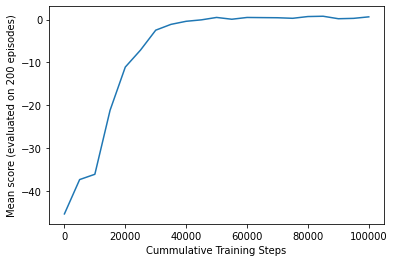

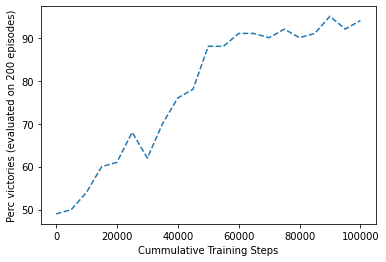

In [33]:
x_ind = [x*train_steps for x in range(train_epochs+1)]
plt.plot(x_ind, mean_score_evaluations)
plt.ylabel('Mean score (evaluated on {} episodes)'.format(eval_epochs))
plt.xlabel('Cummulative Training Steps')
plt.show()

plt.plot(x_ind, perc_victories, label='percentage victories', linestyle='dashed')
plt.ylabel('Perc victories (evaluated on {} episodes)'.format(eval_epochs))
plt.xlabel('Cummulative Training Steps')
plt.show()

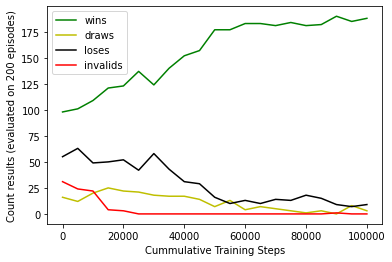

In [34]:
plt.plot(x_ind, wins, 'g', label="wins")
plt.plot(x_ind, draws, 'y', label="draws")
plt.plot(x_ind, loses, 'k', label="loses")
plt.plot(x_ind, invalids, 'r', label="invalids")

plt.ylabel('Count results (evaluated on {} episodes)'.format(eval_epochs))
plt.xlabel('Cummulative Training Steps')
plt.legend(loc="upper left")
plt.show()

In [35]:
download_model(save_dir_ppo, save_name_ppo)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model downloaded!


In [36]:
name_mean_file = os.path.abspath(os.getcwd())+'/resultPPO_mean_3row_reward'+str(rewardvalue)+'_ai'+str(AI)+'_stepstrain'+str(train_steps)+'_meaneval'+str(eval_epochs)+'.txt'
with open(name_mean_file, 'w') as fopen:
  for el in mean_score_evaluations:
    fopen.write(str(el)+'\n')
  
files.download(name_mean_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Checkings

## Show example vs AI

In [37]:
ppo_model_loaded = load_model(save_dir_ppo, save_name_ppo, 'PPO2')


Model loaded!


In [38]:
env_show = Game3RowEnv(3, 3, reward=2, vsAI=1)
observation = env_show.reset()
for t in range(10):
  action, _states = ppo_model_loaded.predict(observation)
  observation, reward, done, info = env_show.step(action)
  env_show.render('colab')
  
  if done:
    print(info)
    break

[[1 0 0]
 [0 1 0]
 [2 2 1]]
{'finished': 'win', 'list_moves': [4, 0, 8], 'list_states': [[[0, 0, 0], [0, 1, 0], [0, 0, 0]], [[1, 0, 0], [0, 1, 0], [0, 2, 0]], [[1, 0, 0], [0, 1, 0], [2, 2, 1]]], 'step': 3}


## Play Yourself

In [39]:
ppo_model_loaded = load_model(save_dir_ppo, save_name_ppo, 'PPO2')

Model loaded!


In [40]:
def move_player(GameEnv): #the player makes a movement and returns the new table
  is_valid = False
  while not is_valid:
    pos = 0
    while pos not in range(1, 10):
        print("Input a valid position (1-9):")
        pos = int(input())

    is_valid = GameEnv.player_move(pos)
    if not is_valid:
      print('--Invalid move!')
  
  new_board = GameEnv.return_board()
  return new_board


In [44]:

env_player = Game3RowEnv(3, 3, reward=1, vsAI=0)
observation = env_show.reset()
for t in range(10):
  loser = False
  action, _states = ppo_model_loaded.predict(observation)
  observation, reward, done, info = env_player.step(action)
  env_player.render('terminal')
  
  if not done: #if the model hasnt win already you can move
    observation = move_player(env_player)
    env_player.render('terminal')
    loser = env_player.check_winner()
    draw = env_player.check_draw()
    if loser or draw:
      done = True
  
  if done:
    if loser:
      print('The player won!')
    elif info['finished'] == 'draw' or draw:
      print('Its a draw!')
    else:
      print('The AI won!')

    print(info)
    break

[[0 0 0]
 [0 1 0]
 [0 0 0]]
Input a valid position (1-9):
3
move 0 2
[[0 0 2]
 [0 1 0]
 [0 0 0]]
[[1 0 2]
 [0 1 0]
 [0 0 0]]
Input a valid position (1-9):
9
move 2 2
[[1 0 2]
 [0 1 0]
 [0 0 2]]
[[1 0 2]
 [0 1 0]
 [1 0 2]]
Input a valid position (1-9):
4
move 1 0
[[1 0 2]
 [2 1 0]
 [1 0 2]]
[[1 0 2]
 [2 1 0]
 [1 1 2]]
Input a valid position (1-9):
2
move 0 1
[[1 2 2]
 [2 1 0]
 [1 1 2]]
[[1 2 2]
 [2 1 1]
 [1 1 2]]
Its a draw!
{'finished': 'draw', 'list_moves': [4, 0, 6, 7, 5], 'list_states': [[[0, 0, 0], [0, 1, 0], [0, 0, 0]], [[1, 0, 2], [0, 1, 0], [0, 0, 0]], [[1, 0, 2], [0, 1, 0], [1, 0, 2]], [[1, 0, 2], [2, 1, 0], [1, 1, 2]], [[1, 2, 2], [2, 1, 1], [1, 1, 2]]], 'step': 5}
